In [1]:
import pandas as pd
import random
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score

# Importing Data

In [2]:
data_train = pd.read_csv('Mushroom_datasets/mushroom_train.csv')
data_test = pd.read_csv('Mushroom_datasets/mushroom_test.csv')
data_train.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season,class
0,4.98,c,i,y,f,a,c,n,6.04,6.21,w,f,f,d,a,p
1,2.84,x,y,y,f,a,c,w,5.66,3.55,y,t,r,h,u,p
2,11.44,x,y,y,f,a,c,w,7.03,25.29,n,t,e,d,w,e
3,8.77,s,t,r,t,d,c,g,4.44,13.61,r,f,f,d,a,p
4,7.55,x,d,n,t,p,c,y,8.41,18.44,y,f,f,d,a,e


# Trival System

In [3]:
N = data_train.shape[0]
N1 = data_train[data_train['class']=='p'].shape[0]
N2 = data_train[data_train['class']=='e'].shape[0]
N_test = data_test['class'].shape[0]
y_pred = []

for _ in range(N_test):
    if random.random() < N1/N:
        y_pred.append('p')
    else:
        y_pred.append('e')

acc = 0
for i in range(N_test):
    if y_pred[i] == data_test['class'][i]:
        acc+=1
        
print("Accuracy of test dataset is", acc*100/N, "%")

Accuracy of test dataset is 21.59165341068588 %


In [4]:
f_score = f1_score(data_test['class'], y_pred, pos_label='e')
print("F1 score:", f_score)

F1 score: 0.44250935181210527


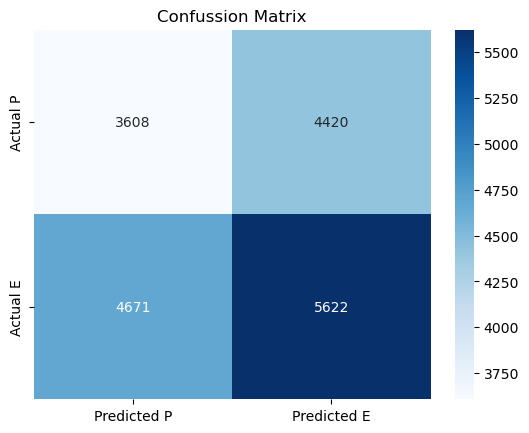

In [5]:
cm = confusion_matrix(data_test['class'], y_pred)
cm_df = pd.DataFrame(cm, index=['Actual P', 'Actual E'], columns=['Predicted P', 'Predicted E'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title("Confussion Matrix")
plt.show()

# One-Hot Encoding

In [6]:
classes = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']
for i in classes:
    print("Unique values of", i, ':', data_train[i].unique())
    data_train = pd.get_dummies(data_train, columns=[i])
    data_test = pd.get_dummies(data_test, columns=[i])

Unique values of cap-shape : ['c' 'x' 's' 'o' 'f' 'b' 'p']
Unique values of cap-surface : ['i' 'y' 't' 'd' 'g' 'h' 'k' 's' 'e' 'w' 'l']
Unique values of cap-color : ['y' 'r' 'n' 'w' 'g' 'k' 'o' 'l' 'e' 'u' 'b' 'p']
Unique values of does-bruise-or-bleed : ['f' 't']
Unique values of gill-attachment : ['a' 'd' 'p' 'x' 'e' 'f' 's']
Unique values of gill-spacing : ['c' 'd' 'f']
Unique values of gill-color : ['n' 'w' 'g' 'y' 'p' 'k' 'f' 'b' 'e' 'o' 'r' 'u']
Unique values of stem-color : ['w' 'y' 'n' 'r' 'o' 'g' 'l' 'e' 'u' 'f' 'k' 'p' 'b']
Unique values of has-ring : ['f' 't']
Unique values of ring-type : ['f' 'r' 'e' 'z' 'l' 'p' 'g' 'm']
Unique values of habitat : ['d' 'h' 'g' 'l' 'm' 'w' 'p' 'u']
Unique values of season : ['a' 'u' 'w' 's']


In [7]:
data_train.head()

,cap-diameter,stem-height,stem-width,class,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_p,cap-shape_s,...,habitat_h,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,season_a,season_s,season_u,season_w
0,4.98,6.04,6.21,p,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2.84,5.66,3.55,p,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,11.44,7.03,25.29,e,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,8.77,4.44,13.61,p,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,7.55,8.41,18.44,e,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Baseline System

In [8]:
X_train = data_train.drop('class', axis=1)
y_train = data_train['class']
X_test = data_test.drop('class', axis=1)
y_test = data_test['class']
class_means = X_train.groupby(y_train).mean()
    
y_pred = []
class_labels = class_means.index.values
for i in range(len(X_test)):
    distances = []
    for j in range(len(class_means)):
        dist = euclidean(X_test.iloc[i], class_means.iloc[j])
        distances.append(dist)
    pred_idx = distances.index(min(distances))
    pred_label = class_labels[pred_idx]
    y_pred.append(pred_label)
    
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of test dataset:", accuracy*100, "%")

Accuracy of test dataset: 60.34605097975001 %


In [9]:
f_score = f1_score(y_test, y_pred, pos_label='e')
print("F1 score:", f_score)

F1 score: 0.5364639826453136


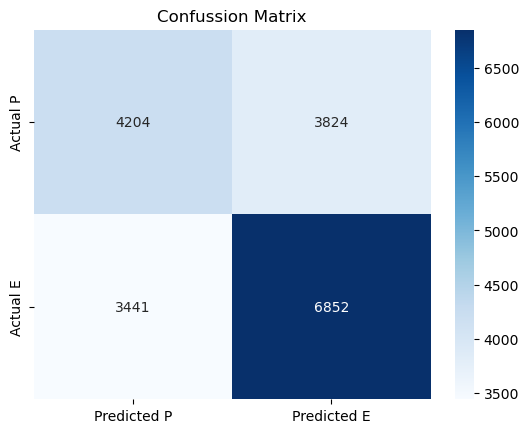

In [10]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual P', 'Actual E'], columns=['Predicted P', 'Predicted E'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title("Confussion Matrix")
plt.show()

# Using PCA feature engineering

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=34)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.fit_transform(X_test)

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_pca_train, y_train)
y_pred = lr.predict(X_pca_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of test dataset:", accuracy*100, "%")

Accuracy of test dataset: 69.55406364281426 %


# Using FDA feature engineering

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

fld = LinearDiscriminantAnalysis(n_components=1)
fld.fit(X_train, y_train)

X_train_fld = fld.transform(X_train)
X_test_fld = fld.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_fld, y_train)
y_pred = lr.predict(X_test_fld)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of test dataset:", accuracy*100, "%")

Accuracy of test dataset: 77.31564870913161 %


In [14]:
X_train.corr()

,cap-diameter,stem-height,stem-width,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_p,cap-shape_s,cap-shape_x,...,habitat_h,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,season_a,season_s,season_u,season_w
cap-diameter,1.000000,0.423171,0.695804,-0.191519,-0.099040,0.022730,0.133587,0.094008,0.053706,-0.007314,...,-0.064857,-0.044482,-0.040500,-0.050547,0.026136,-0.002765,-0.034119,0.033431,-0.008742,0.051043
stem-height,0.423171,1.000000,0.436069,0.015604,-0.008988,0.003152,-0.261647,0.287276,-0.113514,0.070046,...,-0.044873,-0.031233,0.033949,-0.048805,0.160757,-0.048284,0.022103,-0.039386,0.003985,-0.016923
stem-width,0.695804,0.436069,1.000000,-0.221537,-0.083040,-0.024715,0.102138,0.143271,0.073258,0.026121,...,-0.097291,0.002066,-0.056467,0.028929,0.001503,0.002918,-0.004233,-0.007676,-0.020945,0.049504
cap-shape_b,-0.191519,0.015604,-0.221537,1.000000,-0.056965,-0.170293,-0.079120,-0.068233,-0.118677,-0.286469,...,-0.018837,-0.058868,0.095214,-0.024538,-0.014341,-0.025234,-0.037119,0.073950,0.023704,-0.029967
cap-shape_c,-0.099040,-0.008988,-0.083040,-0.056965,1.000000,-0.092869,-0.043148,-0.037211,-0.064720,-0.156226,...,-0.001900,0.064052,-0.039467,0.102637,-0.007821,-0.013761,-0.022261,0.070587,0.023723,-0.054006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
habitat_w,-0.002765,-0.048284,0.002918,-0.025234,-0.013761,0.055348,-0.019113,-0.016483,-0.028669,0.007923,...,-0.014598,-0.018377,-0.017482,-0.005928,-0.003464,1.000000,0.002077,-0.017119,0.019087,-0.023923
season_a,-0.034119,0.022103,-0.004233,-0.037119,-0.022261,0.025897,-0.097923,-0.012340,0.020338,0.045363,...,0.033111,-0.004018,-0.021324,0.005169,-0.022579,0.002077,1.000000,-0.216001,-0.764364,-0.301842
season_s,0.033431,-0.039386,-0.007676,0.073950,0.070587,-0.058596,0.182091,0.083167,-0.080515,-0.085326,...,-0.018717,0.014570,0.040049,-0.016648,0.040769,-0.017119,-0.216001,1.000000,-0.170138,-0.067186
season_u,-0.008742,0.003985,-0.020945,0.023704,0.023723,-0.031489,-0.002368,-0.011584,0.028701,-0.008872,...,0.007041,-0.035152,0.012906,0.015309,-0.015888,0.019087,-0.764364,-0.170138,1.000000,-0.237753
